In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Optional, Sequence, Tuple, Iterable

from datetime import datetime

In [3]:
df = pd.read_csv('Camp_Market_Cleaned.csv', sep=",")
df.columns = df.columns.str.strip()


In [ ]:
def compute_kpis(
    df: pd.DataFrame,
    spend_cols: Optional[Sequence[str]] = ("MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"),
    purchase_cols: Optional[Sequence[str]] = ("NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"),
    income_candidates: Tuple[str,str] = ("income"),
    id_col: str = "ID",
    response_col: str = "Response",
    recency_col: str = "Recency",
    round_ndigits: int = 2,
    format_output: bool = True,
):
    # --- required columns
    if id_col not in df.columns:
        raise KeyError(f"Column '{id_col}' not found.")
    if response_col not in df.columns:
        raise KeyError(f"Column '{response_col}' not found.")

    # choose best income column if present
    income_col = next((c for c in income_candidates if c in df.columns), None)

    spend_cols = [c for c in (spend_cols or []) if c in df.columns]
    purchase_cols = [c for c in (purchase_cols or []) if c in df.columns]

    if len(spend_cols) == 0:
        raise ValueError("No spend columns found among expected  ones.")
    if len(purchase_cols) == 0:
        raise ValueError("No purchase-count columns found among expected ones.")

    df_out = df.copy()

    # numeric coercion
    def _to_numeric_cols(frame: pd.DataFrame, cols: Iterable[str]) -> None:
        for c in cols:
            frame[c] = pd.to_numeric(frame[c], errors="coerce")

    _to_numeric_cols(df_out, spend_cols + purchase_cols)
    if income_col:
        _to_numeric_cols(df_out, [income_col])
    if recency_col in df_out.columns:
        _to_numeric_cols(df_out, [recency_col])

    # totals
    df_out["Spent"] = df_out[spend_cols].sum(axis=1, min_count=1).fillna(0)
    df_out["total_purchases"] = df_out[purchase_cols].sum(axis=1, min_count=1).fillna(0)

    # counts
    n_customers = df_out[id_col].nunique()

    # response rate (handles 0/1/bool/strings FR/EN)
    resp = df_out[response_col]
    if pd.api.types.is_numeric_dtype(resp):
        response_rate = float(pd.to_numeric(resp, errors="coerce").mean()) * 100
    else:
        truthy = {"1","yes","true","y","oui","o","vrai","si"}
        response_rate = resp.astype(str).str.strip().str.lower().isin(truthy).mean() * 100

    # KPIs
    avg_income = df_out[income_col].mean() if income_col else np.nan
    total_revenue = df_out["total_spend"].sum()
    total_purchases = df_out["total_purchases"].sum()
    avg_freq = df_out["total_purchases"].mean()
    aov = (total_revenue / total_purchases) if total_purchases > 0 else np.nan
    avg_recency = df_out[recency_col].mean() if recency_col in df_out.columns else np.nan

    deal_numer = df_out["numdealspurchases"].sum() if "numdealspurchases" in df_out.columns else 0.0
    deal_rate = (deal_numer / total_purchases * 100) if total_purchases > 0 else np.nan

    kpi_summary = pd.DataFrame(
        {
            "Metric": [
                "Total Customers",
                "Response Rate (%)",
                "Average Income",
                "Total Revenue (proxy)",
                "Total Purchases",
                "Average Purchase Frequency",
                "Average Order Value (AOV)",
                "Average Recency (days)",
                "Deal Rate (%)",
            ],
            "Value": [
                n_customers,
                response_rate,
                avg_income,
                total_revenue,
                total_purchases,
                avg_freq,
                aov,
                avg_recency,
                deal_rate,
            ],
        }
    )

    if format_output:
        def _fmt(x, ndigits=round_ndigits):
            return np.nan if pd.isna(x) else round(float(x), ndigits)
        pct_mask = kpi_summary["Metric"].isin(["Response Rate (%)","Deal Rate (%)"])
        kpi_summary.loc[pct_mask, "Value"] = kpi_summary.loc[pct_mask, "Value"].map(lambda x: _fmt(x, 2))
        kpi_summary.loc[~pct_mask, "Value"] = kpi_summary.loc[~pct_mask, "Value"].map(_fmt)

    return df_out, kpi_summary


In [5]:
df_enriched, kpi_summary = compute_kpis(
    df,
    id_col="ID",
    response_col="Response",
    spend_cols=["spent"],             # ← wrap in a list
    purchase_cols=["NumWebPurchases", "NumStorePurchases", "NumCatalogPurchases", "NumDealsPurchases"],  # adjust to your exact names
    format_output=True
)
display(kpi_summary)
# View
display(kpi_summary)

# Optional: save for sharing/reporting
kpi_summary.to_csv("kpi_summary.csv", index=False)
kpi_summary.to_excel("kpi_summary.xlsx", index=False)
df_enriched.to_csv("Camp_Market_enriched_with_totals.csv", index=False)

print("Saved: kpi_summary.csv, kpi_summary.xlsx, Camp_Market_enriched_with_totals.csv")


ValueError: No spend columns found among expected ones.

In [ ]:
import re

print(df.columns.tolist())

income_like = [c for c in df.columns if re.search(r"(income|salary|revenue|earnings|yearly|annual)", c, flags=re.I)]
recency_like = [c for c in df.columns if re.search(r"(recency|days_since|daysfrom|days_last|last_purchase|lastorder)", c, flags=re.I)]

print("Income-like:", income_like)
print("Recency-like:", recency_like)

['ID', 'Income', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Nmb_Childrens', 'Total_Mnt', 'age', 'spent', 'living_with', 'children', 'family_size', 'is_parent', 'education2', 'customer_for', 'purchase_freq', 'age_group']
Income-like: ['Income', 'Z_Revenue']
Recency-like: ['Recency']


In [ ]:
df_enriched, kpi_summary = compute_kpis(
    df,
    id_col="ID",
    response_col="Response",
    spend_cols=["spent"],  # keep your chosen spend columns here
    purchase_cols=["NumWebPurchases","NumStorePurchases","NumCatalogPurchases","NumDealsPurchases"],  # adjust to your file
    # teach the function which column to treat as income
    income_candidates=("Income","income","income_imputed"),
    # teach the function which column is recency
    # if your column is named 'RecencyDays', set recency_col="RecencyDays"
    recency_col="RecencyDays",
    format_output=True
)
display(kpi_summary)

,Metric,Value
0,Total Customers,2039.00
1,Response Rate (%),14.86
2,Average Income,52342.89
3,Total Revenue (proxy),1235371.00
4,Total Purchases,30297.00
5,Average Purchase Frequency,14.86
6,Average Order Value (AOV),40.78
7,Average Recency (days),NaN
8,Deal Rate (%),0.00


In [ ]:
# ===========================
# 0) PARAMÈTRES & MAPPINGS
# ===========================
ID_COL = "ID"
RESPONSE_COL = "Response"             # ex: "Response" (1/0, True/False, yes/no)
INCOME_CANDIDATES = ("Income","income","income_imputed")
RECENCY_COL = "RecencyDays"           # mets le bon nom si dispo, sinon laisse None
RECENCY_COL = RECENCY_COL if RECENCY_COL in df.columns else None

# Colonnes d'achat par canal (ajuste selon ton fichier)
PURCHASE_COLS = [
    "NumWebPurchases", "NumStorePurchases", "NumCatalogPurchases", "NumDealsPurchases"
]
PURCHASE_COLS = [c for c in PURCHASE_COLS if c in df.columns]

# Colonnes de dépense (si tu as un total unique "spent", mets ["spent"])
SPEND_COLS = ["spent"]  # ou ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"] si dispo
SPEND_COLS = [c for c in SPEND_COLS if c in df.columns]

# (Optionnel) mapping lisible pour les canaux
CHANNEL_MAP = {
    "NumWebPurchases":    "Web",
    "NumStorePurchases":  "Store",
    "NumCatalogPurchases":"Catalog",
    "NumDealsPurchases":  "Deals"
}

# Segments à tester pour l'AOV par segment (prends ceux qui existent)
SEGMENT_CANDIDATES = [
    "Education","Marital_Status","Country","Region","AgeGroup","IncomeTier","Customer_Segment"
]
SEGMENTS = [s for s in SEGMENT_CANDIDATES if s in df.columns]

# ===========================
# 1) PRÉPA DONNÉES
# ===========================
import numpy as np
import pandas as pd

assert ID_COL in df.columns, f"Colonne {ID_COL} absente."
assert RESPONSE_COL in df.columns, f"Colonne {RESPONSE_COL} absente."
assert len(PURCHASE_COLS)>0, "Aucune colonne d'achats trouvée. Renseigne PURCHASE_COLS."
assert len(SPEND_COLS)>0, "Aucune colonne de dépense trouvée. Renseigne SPEND_COLS."

dfw = df.copy()
# conversions numériques
for c in PURCHASE_COLS + SPEND_COLS + list(INCOME_CANDIDATES):
    if c in dfw.columns:
        dfw[c] = pd.to_numeric(dfw[c], errors="coerce")
if RECENCY_COL:
    dfw[RECENCY_COL] = pd.to_numeric(dfw[RECENCY_COL], errors="coerce")

# agrégats
dfw["total_spend"] = dfw[SPEND_COLS].sum(axis=1, min_count=1).fillna(0)
dfw["total_purchases"] = dfw[PURCHASE_COLS].sum(axis=1, min_count=1).fillna(0)

# income (si dispo)
income_col = next((c for c in INCOME_CANDIDATES if c in dfw.columns), None)

# binaire réponse
resp = dfw[RESPONSE_COL]
if pd.api.types.is_numeric_dtype(resp):
    dfw["_response_bin"] = pd.to_numeric(resp, errors="coerce").fillna(0).astype(int).clip(0,1)
else:
    truthy = {"1","yes","true","y","oui","o","vrai","si"}
    dfw["_response_bin"] = resp.astype(str).str.strip().str.lower().isin(truthy).astype(int)

# ===========================
# 2) KPIs DE BASE
# ===========================
n_customers = dfw[ID_COL].nunique()
response_rate = dfw["_response_bin"].mean()*100
total_revenue = dfw["total_spend"].sum()
total_purchases = dfw["total_purchases"].sum()
avg_freq = dfw["total_purchases"].mean()
aov = total_revenue/total_purchases if total_purchases>0 else np.nan
avg_recency = dfw[RECENCY_COL].mean() if RECENCY_COL else np.nan
avg_income = dfw[income_col].mean() if income_col else np.nan

# Taux "deal" si colonne Deals présente
deal_col = next((c for c in PURCHASE_COLS if c.lower().startswith("numdeal")), None)
deal_numer = dfw[deal_col].sum() if deal_col else np.nan
deal_rate = (deal_numer/total_purchases*100) if (deal_col and total_purchases>0) else np.nan

kpi_base = pd.DataFrame({
    "Metric":[
        "Total Customers","Response Rate (%)","Average Income","Total Revenue (proxy)",
        "Total Purchases","Average Purchase Frequency","Average Order Value (AOV)",
        "Average Recency (days)","Deal Rate (%)"
    ],
    "Value":[
        n_customers, round(response_rate,2), 
        (np.nan if pd.isna(avg_income) else round(avg_income,2)),
        round(total_revenue,2), round(total_purchases,2), round(avg_freq,2),
        (np.nan if pd.isna(aov) else round(aov,2)),
        (np.nan if pd.isna(avg_recency) else round(avg_recency,2)),
        (np.nan if pd.isna(deal_rate) else round(deal_rate,2))
    ]
})

# ===========================
# 3) PANIER MOYEN PAR SEGMENT
# ===========================
aov_by_segment_tables = {}
for seg in SEGMENTS:
    tmp = dfw.groupby(seg, dropna=False).agg(
        customers=(ID_COL, "nunique"),
        total_spend=("total_spend","sum"),
        total_purchases=("total_purchases","sum"),
        response_rate=("_response_bin","mean")
    ).reset_index()
    tmp["AOV"] = tmp["total_spend"]/tmp["total_purchases"]
    tmp["response_rate"] = (tmp["response_rate"]*100).round(2)
    tmp["AOV"] = tmp["AOV"].round(2)
    aov_by_segment_tables[seg] = tmp.sort_values("AOV", ascending=False)

# ===========================
# 4) MEILLEURS CANAUX D’ACHAT
# ===========================
# répartition par canal (volume)
channel_counts = []
for c in PURCHASE_COLS:
    channel_counts.append(
        pd.DataFrame({
            "channel":[CHANNEL_MAP.get(c, c)],
            "purchases":[dfw[c].sum()],
            "customers":[(dfw[c]>0).sum()]
        })
    )
by_channel_volume = pd.concat(channel_counts, ignore_index=True).sort_values("purchases", ascending=False)

# répartition CA par canal (approx) si tu as des dépenses par catégorie/canal.
# Sinon, on utilise la part de volume comme proxy pour répartir le CA total.
by_channel_revenue = by_channel_volume.copy()
by_channel_revenue["revenue_proxy"] = (by_channel_revenue["purchases"]/by_channel_revenue["purchases"].sum())*total_revenue
by_channel_revenue = by_channel_revenue.sort_values("revenue_proxy", ascending=False)

# ===========================
# 5) PROFIL DU CLIENT RÉACTIF
# ===========================
# Numériques: moyenne répondants vs non-répondants + écart
num_cols_interest = ["total_spend","total_purchases"]
if RECENCY_COL: num_cols_interest.append(RECENCY_COL)
if income_col: num_cols_interest.append(income_col)
num_cols_interest = [c for c in num_cols_interest if c in dfw.columns]

prof_num = dfw.groupby("_response_bin")[num_cols_interest].mean().T
prof_num.columns = ["Non-responders","Responders"] if 0 in prof_num.columns and 1 in prof_num.columns else prof_num.columns
if "Responders" in prof_num.columns and "Non-responders" in prof_num.columns:
    prof_num["Delta(Resp-NonResp)"] = prof_num["Responders"] - prof_num["Non-responders"]
prof_num = prof_num.round(2)

# Catégorielles (si présentes) : distribution par segment pour les répondants
prof_cat_tables = {}
for seg in SEGMENTS:
    tab = (
        dfw.assign(_resp=dfw["_response_bin"].map({0:"Non-responders",1:"Responders"}))
          .pivot_table(index=seg, columns="_resp", values=ID_COL, aggfunc="nunique", fill_value=0)
    )
    tab = (tab.T/tab.sum(axis=1)).T * 100  # % par colonne
    prof_cat_tables[seg] = tab.round(1).sort_values(by="Responders", ascending=False) if "Responders" in tab.columns else tab.round(1)

# ===========================
# 6) SCORE CLIENT (RFM + score continu)
# ===========================
# RFM 5-1 (5 = meilleur : récence faible, fréquence/monétaire élevés)
def qscore(series, ascending=False, q=5):
    # renvoie 1..q (1 = plus faible), inverse si ascending=True
    r = pd.qcut(series.rank(method="first"), q, labels=False, duplicates="drop") + 1
    if ascending:  # pour la récence (plus petit = meilleur)
        r = q - r + 1
    return r

# fréq & monetary
dfw["F_score"] = qscore(dfw["total_purchases"].fillna(0), ascending=False, q=5)
dfw["M_score"] = qscore(dfw["total_spend"].fillna(0), ascending=False, q=5)
# récence (si dispo)
if RECENCY_COL:
    dfw["R_score"] = qscore(dfw[RECENCY_COL].fillna(dfw[RECENCY_COL].median()), ascending=True, q=5)
else:
    dfw["R_score"] = 3  # neutre si pas de récence

dfw["RFM_score"] = dfw["R_score"] + dfw["F_score"] + dfw["M_score"]    # 3..15
# Score continu simple (z-score normalisé)
for col in ["total_spend","total_purchases"]:
    mu, sd = dfw[col].mean(), dfw[col].std(ddof=0) or 1.0
    dfw[f"z_{col}"] = (dfw[col]-mu)/sd
if RECENCY_COL:
    mu, sd = dfw[RECENCY_COL].mean(), dfw[RECENCY_COL].std(ddof=0) or 1.0
    dfw["z_recency"] = -(dfw[RECENCY_COL]-mu)/sd  # signe inversé (faible récence = mieux)
else:
    dfw["z_recency"] = 0

dfw["score_continu"] = (0.5*dfw["z_total_spend"] + 0.3*dfw["z_total_purchases"] + 0.2*dfw["z_recency"])

# ===========================
# 7) ÉVALUATION DU MODÈLE / SCORE (Lift par déciles, AUC si proba)
# ===========================
def decile_lift(df_scores, score_col, y_col="_response_bin", q=10):
    tmp = df_scores[[score_col, y_col]].dropna().copy()
    tmp["decile"] = pd.qcut(tmp[score_col].rank(method="first", ascending=False), q, labels=[f"D{i}" for i in range(1,q+1)])
    agg = tmp.groupby("decile").agg(
        n=("decile","size"),
        responders=(y_col,"sum")
    ).reset_index()
    agg["resp_rate"] = agg["responders"]/agg["n"]
    base_rate = tmp[y_col].mean()
    agg["lift"] = agg["resp_rate"]/base_rate
    return agg.sort_values("decile")

# si tu as une proba prédictive (ex: "pred_proba", "score_model")
PRED_PROBA_COL = next((c for c in ["pred_proba","score_model","proba","p_hat"] if c in dfw.columns), None)
eval_tables = {}

# Lift sur score continu
eval_tables["lift_score_continu"] = decile_lift(dfw, "score_continu")

# Lift sur RFM
eval_tables["lift_RFM"] = decile_lift(dfw, "RFM_score")

# Lift sur proba de modèle si dispo
if PRED_PROBA_COL:
    eval_tables["lift_model"] = decile_lift(dfw, PRED_PROBA_COL)

# (optionnel) AUC si sklearn est dispo et proba présente
try:
    if PRED_PROBA_COL:
        from sklearn.metrics import roc_auc_score, average_precision_score
        auc = roc_auc_score(dfw["_response_bin"], dfw[PRED_PROBA_COL])
        ap = average_precision_score(dfw["_response_bin"], dfw[PRED_PROBA_COL])
    else:
        auc = ap = np.nan
except Exception:
    auc = ap = np.nan

# ===========================
# 8) SYNTHÈSE DES KPIs CLÉS
# ===========================
synthese_rows = [
    ("Customers", int(n_customers)),
    ("Response Rate (%)", round(response_rate,2)),
    ("Average Order Value", round(aov,2) if not pd.isna(aov) else np.nan),
    ("Average Frequency", round(avg_freq,2)),
    ("Top Channel (Volume)", by_channel_volume.iloc[0]["channel"] if len(by_channel_volume)>0 else np.nan),
    ("Top Channel (Revenue proxy)", by_channel_revenue.iloc[0]["channel"] if len(by_channel_revenue)>0 else np.nan),
    ("Best Segment by AOV", np.nan if len(SEGMENTS)==0 else max(
        ((seg, aov_by_segment_tables[seg].iloc[0][seg], aov_by_segment_tables[seg].iloc[0]["AOV"]) 
         for seg in SEGMENTS if len(aov_by_segment_tables[seg])>0),
        key=lambda x: x[2]
    )[0] if any(len(aov_by_segment_tables[s])>0 for s in SEGMENTS) else np.nan),
    ("Deal Rate (%)", round(deal_rate,2) if not pd.isna(deal_rate) else np.nan),
    ("AUC (if model)", round(float(auc),4) if not pd.isna(auc) else np.nan),
    ("Avg Precision (if model)", round(float(ap),4) if not pd.isna(ap) else np.nan),
]
kpi_synthese = pd.DataFrame(synthese_rows, columns=["KPI","Value"])

# ===========================
# 9) AFFICHAGE & EXPORTS
# ===========================
from IPython.display import display

print("=== KPIs de base ===")
display(kpi_base)

if SEGMENTS:
    print("=== AOV par segment ===")
    for seg, tab in aov_by_segment_tables.items():
        print(f"\nSegment: {seg}")
        display(tab.head(15))

print("=== Meilleurs canaux (volume) ===")
display(by_channel_volume)

print("=== Meilleurs canaux (revenue proxy) ===")
display(by_channel_revenue)

print("=== Profil réactif (numérique) ===")
display(prof_num)

if SEGMENTS:
    print("=== Profil réactif (catégoriel) ===")
    for seg, tab in prof_cat_tables.items():
        print(f"\nSegment: {seg}")
        display(tab.head(15))

print("=== Lift par déciles ===")
for name, tab in eval_tables.items():
    print(f"\n{name}")
    display(tab)

print("=== Synthèse KPIs clés ===")
display(kpi_synthese)

# Sauvegardes
kpi_base.to_csv("kpi_base.csv", index=False)
by_channel_volume.to_csv("kpi_channels_volume.csv", index=False)
by_channel_revenue.to_csv("kpi_channels_revenue.csv", index=False)
kpi_synthese.to_csv("kpi_synthese.csv", index=False)
dfw.to_csv("Camp_Market_enriched_scored.csv", index=False)


=== KPIs de base ===


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_91779/2541442262.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile").agg(
/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_91779/2541442262.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby("decile").agg(


,Metric,Value
0,Total Customers,2039.00
1,Response Rate (%),14.86
2,Average Income,52342.89
3,Total Revenue (proxy),1235371.00
4,Total Purchases,30297.00
5,Average Purchase Frequency,14.86
6,Average Order Value (AOV),40.78
7,Average Recency (days),NaN
8,Deal Rate (%),15.67


=== Meilleurs canaux (volume) ===


,channel,purchases,customers
1,Store,11770,2024
0,Web,8357,1994
2,Catalog,5421,1505
3,Deals,4749,1997


=== Meilleurs canaux (revenue proxy) ===


,channel,purchases,customers,revenue_proxy
1,Store,11770,2024,479925.955375
0,Web,8357,1994,340759.660924
2,Catalog,5421,1505,221043.211902
3,Deals,4749,1997,193642.171799


=== Profil réactif (numérique) ===


,Non-responders,Responders,Delta(Resp-NonResp)
total_spend,539.67,985.16,445.49
total_purchases,14.37,17.63,3.26
Income,50979.69,60170.00,9190.32


=== Lift par déciles ===

lift_score_continu


,decile,n,responders,resp_rate,lift
0,D1,204,76,0.372549,2.507021
1,D2,204,49,0.240196,1.616369
2,D3,204,33,0.161765,1.088575
3,D4,204,27,0.132353,0.890652
4,D5,204,29,0.142157,0.956627
5,D6,203,16,0.078818,0.530394
6,D7,204,30,0.147059,0.989614
7,D8,204,20,0.098039,0.659742
8,D9,204,15,0.073529,0.494807
9,D10,204,8,0.039216,0.263897



lift_RFM


,decile,n,responders,resp_rate,lift
0,D1,204,65,0.318627,2.144163
1,D2,204,34,0.166667,1.121562
2,D3,204,43,0.210784,1.418446
3,D4,204,40,0.196078,1.319485
4,D5,204,35,0.171569,1.154549
5,D6,203,16,0.078818,0.530394
6,D7,204,26,0.127451,0.857665
7,D8,204,25,0.122549,0.824678
8,D9,204,13,0.063725,0.428833
9,D10,204,6,0.029412,0.197923


=== Synthèse KPIs clés ===


,KPI,Value
0,Customers,2039
1,Response Rate (%),14.86
2,Average Order Value,40.78
3,Average Frequency,14.86
4,Top Channel (Volume),Store
5,Top Channel (Revenue proxy),Store
6,Best Segment by AOV,NaN
7,Deal Rate (%),15.67
8,AUC (if model),NaN
9,Avg Precision (if model),NaN


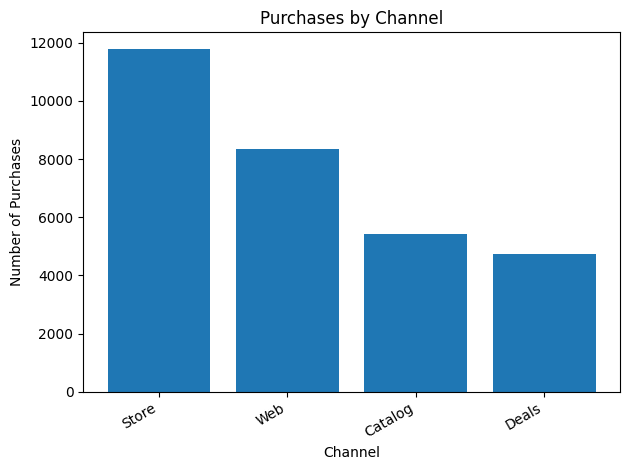

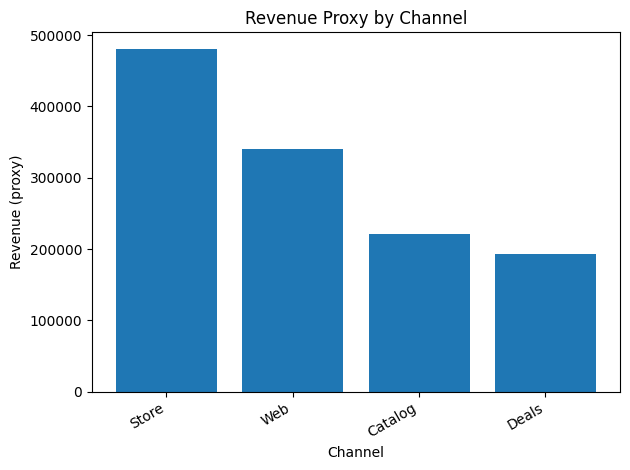

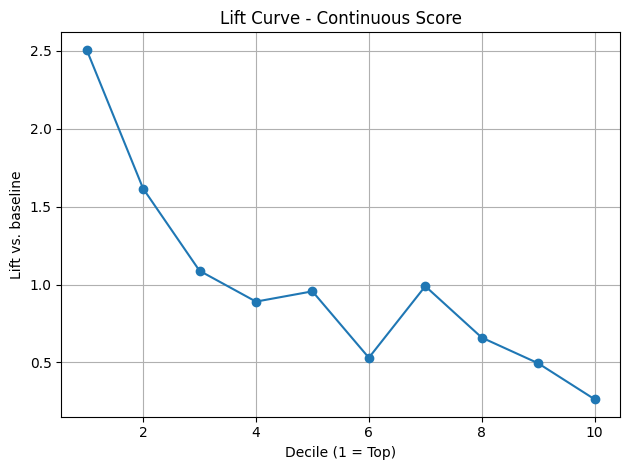

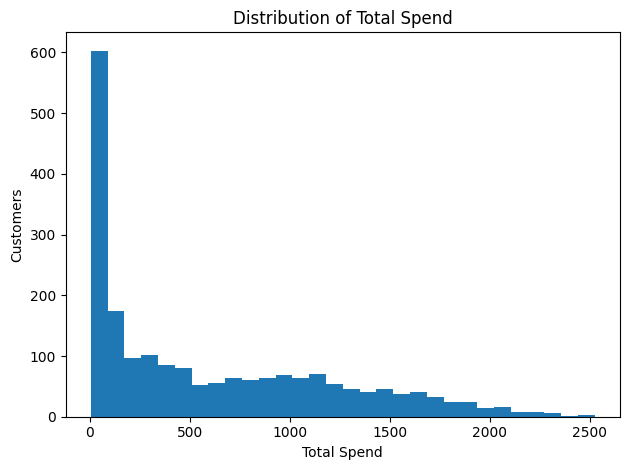

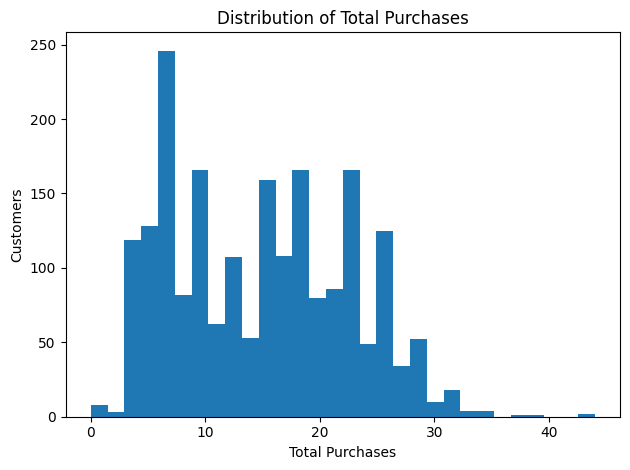

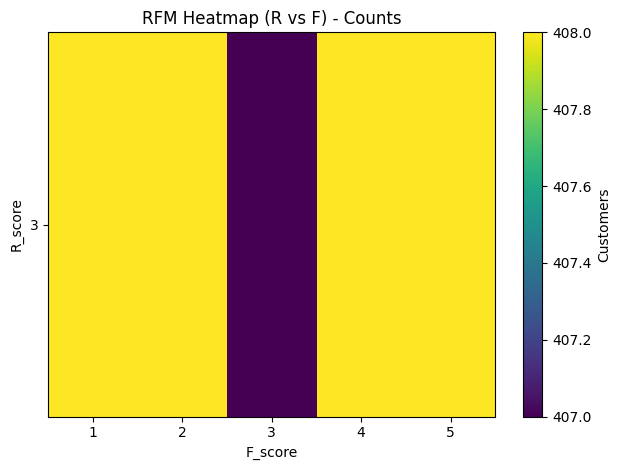

In [ ]:
# ===========================
# 10) VISUALIZATIONS (matplotlib only)
# ===========================
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("plots", exist_ok=True)

def _safe_title(txt, default="Chart"):
    try:
        return str(txt)
    except Exception:
        return default

# 1) Purchases by Channel (Bar)
if 'by_channel_volume' in globals() and len(by_channel_volume) > 0:
    fig = plt.figure()
    x = by_channel_volume['channel'].astype(str).tolist()
    y = by_channel_volume['purchases'].values
    plt.bar(x, y)
    plt.title("Purchases by Channel")
    plt.xlabel("Channel")
    plt.ylabel("Number of Purchases")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig("plots/purchases_by_channel.png", dpi=150)
    plt.show()

# 2) Revenue Proxy by Channel (Bar)
if 'by_channel_revenue' in globals() and len(by_channel_revenue) > 0:
    fig = plt.figure()
    x = by_channel_revenue['channel'].astype(str).tolist()
    y = by_channel_revenue['revenue_proxy'].values
    plt.bar(x, y)
    plt.title("Revenue Proxy by Channel")
    plt.xlabel("Channel")
    plt.ylabel("Revenue (proxy)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig("plots/revenue_proxy_by_channel.png", dpi=150)
    plt.show()

# 3) Response Rate by Top Segment (auto-picks the first available segment)
if 'aov_by_segment_tables' in globals() and len(aov_by_segment_tables) > 0:
    # pick the first segment that has rows
    chosen_seg = None
    for seg, tab in aov_by_segment_tables.items():
        if tab is not None and len(tab) > 0 and 'response_rate' in tab.columns:
            chosen_seg = seg
            break

    if chosen_seg:
        tab = aov_by_segment_tables[chosen_seg].copy()
        # keep top 12 for readability
        tab = tab.head(12)
        fig = plt.figure()
        plt.bar(tab[chosen_seg].astype(str), tab['response_rate'].values)
        plt.title(f"Response Rate by {chosen_seg}")
        plt.xlabel(_safe_title(chosen_seg))
        plt.ylabel("Response Rate (%)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(f"plots/response_rate_by_{chosen_seg}.png", dpi=150)
        plt.show()

# 4) Lift Curve (score_continu if available, else RFM)
if 'eval_tables' in globals():
    if "lift_score_continu" in eval_tables and len(eval_tables["lift_score_continu"]) > 0:
        lift = eval_tables["lift_score_continu"]
        fig = plt.figure()
        # ensure sorted by decile label order D1..D10
        xs = list(range(1, len(lift)+1))
        ys = lift.sort_values("decile")["lift"].values
        plt.plot(xs, ys, marker="o")
        plt.title("Lift Curve - Continuous Score")
        plt.xlabel("Decile (1 = Top)")
        plt.ylabel("Lift vs. baseline")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("plots/lift_curve_score_continu.png", dpi=150)
        plt.show()
    elif "lift_RFM" in eval_tables and len(eval_tables["lift_RFM"]) > 0:
        lift = eval_tables["lift_RFM"]
        fig = plt.figure()
        xs = list(range(1, len(lift)+1))
        ys = lift.sort_values("decile")["lift"].values
        plt.plot(xs, ys, marker="o")
        plt.title("Lift Curve - RFM")
        plt.xlabel("Decile (1 = Top)")
        plt.ylabel("Lift vs. baseline")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("plots/lift_curve_rfm.png", dpi=150)
        plt.show()

# 5) Distributions: Total Spend & Total Purchases (Histograms)
if 'dfw' in globals():
    if "total_spend" in dfw.columns:
        fig = plt.figure()
        plt.hist(dfw["total_spend"].dropna().values, bins=30)
        plt.title("Distribution of Total Spend")
        plt.xlabel("Total Spend")
        plt.ylabel("Customers")
        plt.tight_layout()
        plt.savefig("plots/dist_total_spend.png", dpi=150)
        plt.show()

    if "total_purchases" in dfw.columns:
        fig = plt.figure()
        plt.hist(dfw["total_purchases"].dropna().values, bins=30)
        plt.title("Distribution of Total Purchases")
        plt.xlabel("Total Purchases")
        plt.ylabel("Customers")
        plt.tight_layout()
        plt.savefig("plots/dist_total_purchases.png", dpi=150)
        plt.show()

# 6) RFM Heatmap (R vs F counts) using matplotlib imshow
if 'dfw' in globals() and {"R_score","F_score"}.issubset(dfw.columns):
    pivot_r_f = (
        dfw.pivot_table(index="R_score", columns="F_score", values=ID_COL, aggfunc="count", fill_value=0)
        .sort_index(ascending=True)   # R 1..5
        .reindex(sorted(dfw["F_score"].unique()), axis=1)  # F 1..5
    )
    fig = plt.figure()
    plt.imshow(pivot_r_f.values, aspect="auto")
    plt.title("RFM Heatmap (R vs F) - Counts")
    plt.xlabel("F_score")
    plt.ylabel("R_score")
    plt.colorbar(label="Customers")
    # tick labels
    plt.xticks(ticks=range(pivot_r_f.shape[1]), labels=pivot_r_f.columns.astype(str))
    plt.yticks(ticks=range(pivot_r_f.shape[0]), labels=pivot_r_f.index.astype(str))
    plt.tight_layout()
    plt.savefig("plots/heatmap_r_vs_f.png", dpi=150)
    plt.show()


In [ ]:
# ===========================
# 11) Segmented KPIs (robust + with visuals)
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

os.makedirs("plots", exist_ok=True)

# --- Preconditions ---
assert 'dfw' in globals(), "dfw not found — run the main KPI block first."
RESPONSE_COL = RESPONSE_COL if 'RESPONSE_COL' in globals() else 'Response'
if RESPONSE_COL not in dfw.columns:
    raise KeyError(f"Response column '{RESPONSE_COL}' not found in dfw. Available: {list(dfw.columns)}")

# --- Ensure binary response is present ---
if "_response_bin" not in dfw.columns:
    resp = dfw[RESPONSE_COL]
    if pd.api.types.is_numeric_dtype(resp):
        dfw["_response_bin"] = pd.to_numeric(resp, errors="coerce").fillna(0).astype(int).clip(0,1)
    else:
        truthy = {"1","yes","true","y","oui","o","vrai","si"}
        dfw["_response_bin"] = resp.astype(str).str.strip().str.lower().isin(truthy).astype(int)

print(f"[Info] Rows in dfw: {len(dfw):,}")
print(f"[Info] Columns present: {sorted(dfw.columns.tolist())[:12]} ...")

def _group_and_plot(cat_col, title_label, filename_prefix):
    """Group by cat_col -> response rate + n; display and plot if data exists."""
    if cat_col not in dfw.columns:
        print(f"[Skip] Column '{cat_col}' not found — no {title_label} KPI.")
        return None

    tbl = (dfw.groupby(cat_col)["_response_bin"]
             .agg(response_rate="mean", n="count")
             .reset_index())
    if tbl.empty:
        print(f"[Skip] '{cat_col}' produced an empty table — no data to plot.")
        return None

    tbl["response_rate"] = (tbl["response_rate"] * 100).round(2)
    tbl = tbl.sort_values("response_rate", ascending=False)

    print(f"\n=== Response Rate by {title_label} ===")
    display(tbl)

    # Plot bar
    plt.figure()
    plt.bar(tbl[cat_col].astype(str), tbl["response_rate"])
    plt.title(f"Response Rate by {title_label}")
    plt.xlabel(title_label)
    plt.ylabel("Response Rate (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    out = f"plots/response_rate_by_{filename_prefix}.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print(f"[Saved] {out}")

    # Optional: distribution pie by counts
    plt.figure()
    plt.pie(tbl["n"], labels=tbl[cat_col].astype(str), autopct="%1.1f%%", startangle=140)
    plt.title(f"Customer Distribution by {title_label}")
    plt.tight_layout()
    out2 = f"plots/customer_distribution_{filename_prefix}.png"
    plt.savefig(out2, dpi=150)
    plt.show()
    print(f"[Saved] {out2}")

    return tbl

# 1) Education
edu_resp = _group_and_plot("Education", "Education", "education")

# 2) Marital Status
mar_resp = _group_and_plot("Marital_Status", "Marital Status", "marital_status")

# 3) Age / AgeGroup
if "AgeGroup" not in dfw.columns or dfw["AgeGroup"].isna().all():
    # build Age or AgeGroup if needed
    if "Age" in dfw.columns and dfw["Age"].notna().any():
        bins = [18,25,35,45,55,65,75,100]
        labels = ["18–24","25–34","35–44","45–54","55–64","65–74","75+"]
        dfw["AgeGroup"] = pd.cut(pd.to_numeric(dfw["Age"], errors="coerce"), bins=bins, labels=labels, right=False)
    elif "Year_Birth" in dfw.columns and dfw["Year_Birth"].notna().any():
        current_year = pd.Timestamp.now().year
        dfw["Age"] = current_year - pd.to_numeric(dfw["Year_Birth"], errors="coerce")
        bins = [18,25,35,45,55,65,75,100]
        labels = ["18–24","25–34","35–44","45–54","55–64","65–74","75+"]
        dfw["AgeGroup"] = pd.cut(dfw["Age"], bins=bins, labels=labels, right=False)

age_resp = None
if "AgeGroup" in dfw.columns and dfw["AgeGroup"].notna().any():
    age_resp = _group_and_plot("AgeGroup", "Age Group", "agegroup")
    # Also: age histogram (if Age exists)
    if "Age" in dfw.columns and dfw["Age"].notna().any():
        plt.figure()
        plt.hist(dfw["Age"].dropna(), bins=20)
        plt.title("Distribution of Customer Ages")
        plt.xlabel("Age")
        plt.ylabel("Count")
        plt.tight_layout()
        out = "plots/distribution_customer_age.png"
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"[Saved] {out}")
else:
    print("[Skip] No usable AgeGroup — could not compute age KPIs.")

# Save tables if they exist
if isinstance(edu_resp, pd.DataFrame) and not edu_resp.empty:
    edu_resp.to_csv("kpi_response_by_education.csv", index=False)
    print("[Saved] kpi_response_by_education.csv")

if isinstance(mar_resp, pd.DataFrame) and not mar_resp.empty:
    mar_resp.to_csv("kpi_response_by_marital_status.csv", index=False)
    print("[Saved] kpi_response_by_marital_status.csv")

if isinstance(age_resp, pd.DataFrame) and not age_resp.empty:
    age_resp.to_csv("kpi_response_by_agegroup.csv", index=False)
    print("[Saved] kpi_response_by_agegroup.csv")


[Info] Rows in dfw: 2,039
[Info] Columns present: ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AgeGroup', 'Complain', 'Dt_Customer', 'F_score', 'ID', 'Income', 'M_score'] ...
[Skip] Column 'Education' not found — no Education KPI.
[Skip] Column 'Marital_Status' not found — no Marital Status KPI.
[Skip] No usable AgeGroup — could not compute age KPIs.


In [ ]:
import re

cols = dfw.columns.tolist()
print("All columns:", cols)

def find_cols(patterns):
    pats = [re.compile(p, re.I) for p in patterns]
    return [c for c in cols if any(p.search(c) for p in pats)]

edu_candidates = find_cols([r"\bedu", r"education", r"niveau", r"school"])
mar_candidates = find_cols([r"marital", r"mari", r"status", r"statut"])
age_candidates = find_cols([r"age\b", r"year_birth", r"birth", r"dob", r"naissance"])
print("Education-like:", edu_candidates)
print("Marital-like:", mar_candidates)
print("Age-like:", age_candidates)

All columns: ['ID', 'Income', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Nmb_Childrens', 'Total_Mnt', 'age', 'spent', 'living_with', 'children', 'family_size', 'is_parent', 'education2', 'customer_for', 'purchase_freq', 'age_group', 'total_spend', 'total_purchases', '_response_bin', 'F_score', 'M_score', 'R_score', 'RFM_score', 'z_total_spend', 'z_total_purchases', 'z_recency', 'score_continu', 'AgeGroup']
Education-like: ['education2']
Marital-like: []
Age-like: ['age']



=== Segmented KPIs ===


,education2,response_rate,n
0,grad,15.13,337
1,postgrad,20.36,442
2,undergrad,12.86,1260


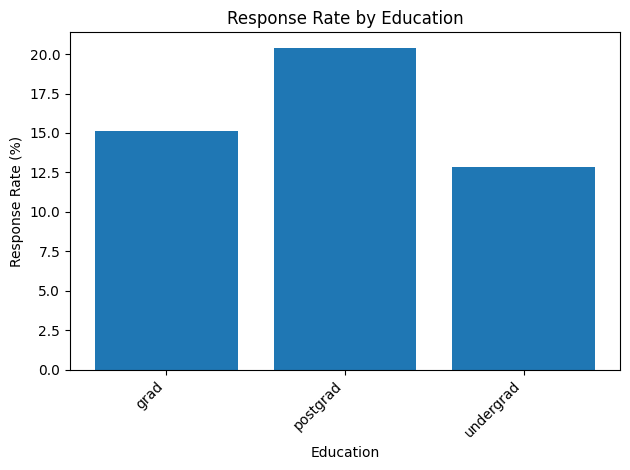

[Saved] plots/response_rate_by_education.png


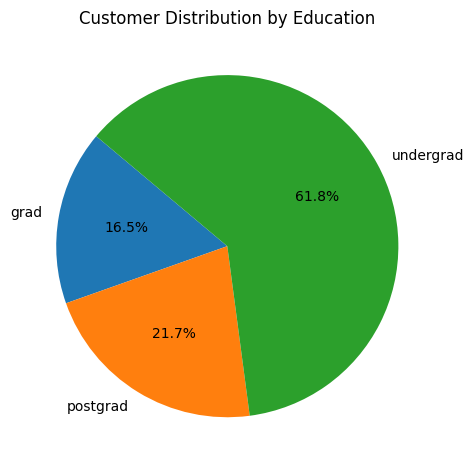

[Saved] plots/customer_distribution_education.png
[Skip] 'Marital Status': column not found.


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_91779/1388286300.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tbl = (dfw.groupby(cat_col)["_response_bin"]


,AgeGroup,response_rate,n
0,18–24,NaN,0
1,25–34,23.68,38
2,35–44,19.74,309
3,45–54,12.66,640
4,55–64,14.67,484
5,65–74,12.61,444
6,75+,20.66,121


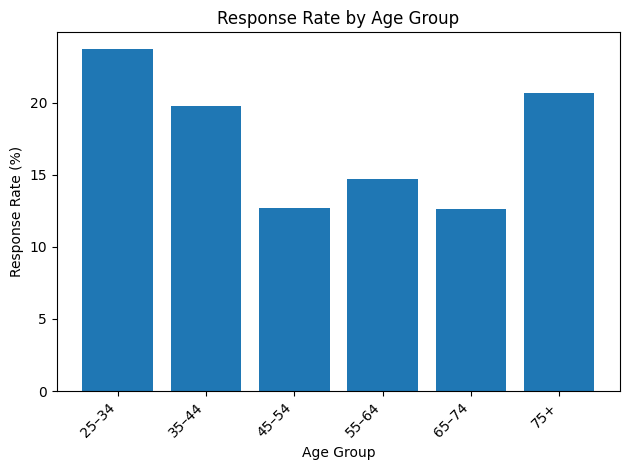

[Saved] plots/response_rate_by_agegroup.png


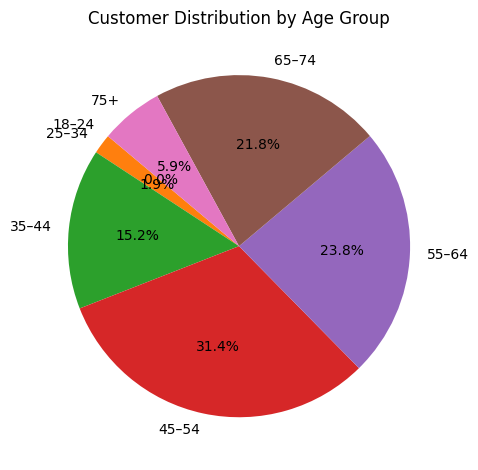

[Saved] plots/customer_distribution_agegroup.png
[Saved] kpi_response_by_education.csv
[Saved] kpi_response_by_agegroup.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.makedirs("plots", exist_ok=True)

# ---- Set your best-guess aliases here based on the prints above ----
EDU_COL = next((c for c in edu_candidates if c in dfw.columns), None)          # e.g. "EducationLevel"
MAR_COL = next((c for c in mar_candidates if c in dfw.columns), None)          # e.g. "MaritalStatus"
AGE_COL = next((c for c in age_candidates if c.lower() == "age"), None)        # exactly "Age" if present
YOB_COL = next((c for c in age_candidates if "year" in c.lower() or "birth" in c.lower()), None)  # e.g. "Year_Birth"

# Ensure response binary
if "_response_bin" not in dfw.columns:
    resp = dfw[RESPONSE_COL]
    if pd.api.types.is_numeric_dtype(resp):
        dfw["_response_bin"] = pd.to_numeric(resp, errors="coerce").fillna(0).astype(int).clip(0,1)
    else:
        truthy = {"1","yes","true","y","oui","o","vrai","si"}
        dfw["_response_bin"] = resp.astype(str).str.strip().str.lower().isin(truthy).astype(int)

# ---- Build/repair Age and AgeGroup if needed ----
if AGE_COL is None and YOB_COL is not None:
    # derive Age from Year_Birth
    current_year = pd.Timestamp.now().year
    dfw["Age"] = current_year - pd.to_numeric(dfw[YOB_COL], errors="coerce")
    AGE_COL = "Age"

if AGE_COL is not None:
    bins = [18,25,35,45,55,65,75,100]
    labels = ["18–24","25–34","35–44","45–54","55–64","65–74","75+"]
    dfw["AgeGroup"] = pd.cut(pd.to_numeric(dfw[AGE_COL], errors="coerce"), bins=bins, labels=labels, right=False)

# ---- Helper: group and plot ----
def group_and_plot(cat_col, title, fname_prefix):
    if not cat_col or cat_col not in dfw.columns:
        print(f"[Skip] '{title}': column not found.")
        return None
    tbl = (dfw.groupby(cat_col)["_response_bin"]
             .agg(response_rate="mean", n="count")
             .reset_index())
    if tbl.empty:
        print(f"[Skip] '{title}': no rows.")
        return None
    tbl["response_rate"] = (tbl["response_rate"]*100).round(2)
    display(tbl)

    # Bar plot
    plt.figure()
    plt.bar(tbl[cat_col].astype(str), tbl["response_rate"])
    plt.title(f"Response Rate by {title}")
    plt.xlabel(title)
    plt.ylabel("Response Rate (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    out = f"plots/response_rate_by_{fname_prefix}.png"
    plt.savefig(out, dpi=150); plt.show(); print("[Saved]", out)

    # Pie distribution
    plt.figure()
    plt.pie(tbl["n"], labels=tbl[cat_col].astype(str), autopct="%1.1f%%", startangle=140)
    plt.title(f"Customer Distribution by {title}")
    plt.tight_layout()
    out2 = f"plots/customer_distribution_{fname_prefix}.png"
    plt.savefig(out2, dpi=150); plt.show(); print("[Saved]", out2)

    return tbl

print("\n=== Segmented KPIs ===")
edu_resp = group_and_plot(EDU_COL, "Education", "education")
mar_resp = group_and_plot(MAR_COL, "Marital Status", "marital_status")
age_resp = group_and_plot("AgeGroup" if "AgeGroup" in dfw.columns else None, "Age Group", "agegroup")

# Save CSVs if produced
if isinstance(edu_resp, pd.DataFrame):
    edu_resp.to_csv("kpi_response_by_education.csv", index=False)
    print("[Saved] kpi_response_by_education.csv")
if isinstance(mar_resp, pd.DataFrame):
    mar_resp.to_csv("kpi_response_by_marital_status.csv", index=False)
    print("[Saved] kpi_response_by_marital_status.csv")
if isinstance(age_resp, pd.DataFrame):
    age_resp.to_csv("kpi_response_by_agegroup.csv", index=False)
    print("[Saved] kpi_response_by_agegroup.csv")


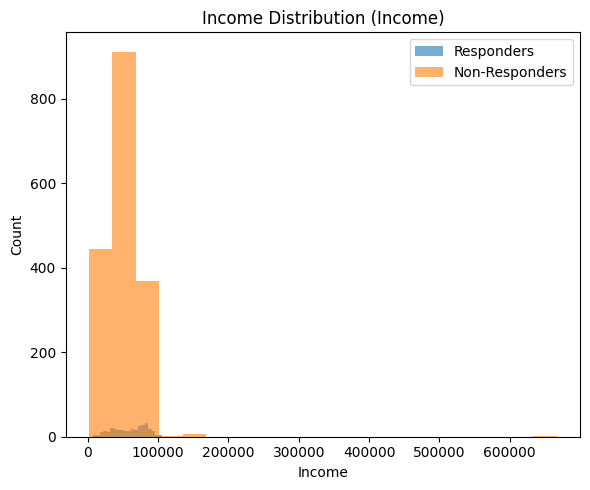

In [ ]:
# =========================================
# KPI Visuals: Age & Income Distributions
# (Responders vs Non-Responders)
# =========================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Config / auto-detects ---
RESPONSE_COL = RESPONSE_COL if 'RESPONSE_COL' in globals() else "Response"
income_candidates = ["Income", "income_imputed", "income"]
yob_candidates = ["Year_Birth", "year_birth", "YEAR_BIRTH"]

assert 'dfw' in globals(), "dfw not found. Run your main KPI block first."
assert RESPONSE_COL in dfw.columns, f"'{RESPONSE_COL}' not in dfw columns."

# Make sure we have a binary response column
if "_response_bin" not in dfw.columns:
    resp = dfw[RESPONSE_COL]
    if pd.api.types.is_numeric_dtype(resp):
        dfw["_response_bin"] = pd.to_numeric(resp, errors="coerce").fillna(0).astype(int).clip(0,1)
    else:
        truthy = {"1","yes","true","y","oui","o","vrai","si"}
        dfw["_response_bin"] = resp.astype(str).str.strip().str.lower().isin(truthy).astype(int)

# Age source: prefer existing Age; else derive from Year_Birth; else None
age_series = None
if "Age" in dfw.columns and dfw["Age"].notna().any():
    age_series = pd.to_numeric(dfw["Age"], errors="coerce")
else:
    yob_col = next((c for c in yob_candidates if c in dfw.columns), None)
    if yob_col is not None:
        current_year = pd.Timestamp.now().year
        age_series = current_year - pd.to_numeric(dfw[yob_col], errors="coerce")

# Income source (first present)
income_col = next((c for c in income_candidates if c in dfw.columns), None)

# Split responders vs non-responders
responders = dfw[dfw["_response_bin"] == 1].copy()
non_responders = dfw[dfw["_response_bin"] == 0].copy()

# Attach age if we computed it ad-hoc
if age_series is not None and "Age" not in dfw.columns:
    dfw["__AgeTemp"] = age_series
    responders["__AgeTemp"] = dfw.loc[responders.index, "__AgeTemp"]
    non_responders["__AgeTemp"] = dfw.loc[non_responders.index, "__AgeTemp"]
    age_col_for_plot = "__AgeTemp"
else:
    age_col_for_plot = "Age" if "Age" in dfw.columns else None

# Decide layout: 1 or 2 panels depending on data availability
make_age = age_col_for_plot is not None and (responders[age_col_for_plot].notna().any() or non_responders[age_col_for_plot].notna().any())
make_income = income_col is not None and (responders[income_col].notna().any() or non_responders[income_col].notna().any())

if not (make_age or make_income):
    print("Nothing to plot: no usable Age or Income columns found.")
else:
    nplots = (1 if make_age and not make_income else 0) + (1 if make_income and not make_age else 0) + (2 if make_age and make_income else 0)
    # Map to subplot shape
    if make_age and make_income:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        ax_age, ax_inc = axes[0], axes[1]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax_age = ax if make_age else None
        ax_inc = ax if make_income else None

    # Panel 1: Age distribution
    if make_age:
        r_age = responders[age_col_for_plot].dropna()
        nr_age = non_responders[age_col_for_plot].dropna()
        # (Optional) clip implausible ages to keep the chart readable
        r_age = r_age[(r_age >= 18) & (r_age <= 100)]
        nr_age = nr_age[(nr_age >= 18) & (nr_age <= 100)]

        ax = ax_age
        ax.hist(r_age, bins=20, alpha=0.6, label="Responders")
        ax.hist(nr_age, bins=20, alpha=0.6, label="Non-Responders")
        ax.set_title("Age Distribution")
        ax.set_xlabel("Age")
        ax.set_ylabel("Count")
        ax.legend()

    # Panel 2: Income distribution
    if make_income:
        r_inc = pd.to_numeric(responders[income_col], errors="coerce").dropna()
        nr_inc = pd.to_numeric(non_responders[income_col], errors="coerce").dropna()

        ax = ax_inc
        ax.hist(r_inc, bins=20, alpha=0.6, label="Responders")
        ax.hist(nr_inc, bins=20, alpha=0.6, label="Non-Responders")
        ax.set_title(f"Income Distribution ({income_col})")
        ax.set_xlabel("Income")
        ax.set_ylabel("Count")
        ax.legend()

    plt.tight_layout()
    plt.show()


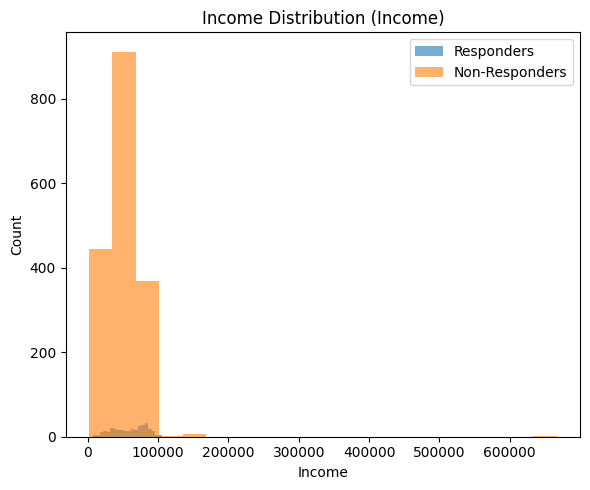

In [ ]:
# =========================================
# KPI Visuals: Age & Income Distributions
# (Responders vs Non-Responders)
# =========================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Config / auto-detects ---
RESPONSE_COL = RESPONSE_COL if 'RESPONSE_COL' in globals() else "Response"
income_candidates = ["Income", "income_imputed", "income"]
yob_candidates = ["Year_Birth", "year_birth", "YEAR_BIRTH"]

assert 'dfw' in globals(), "dfw not found. Run your main KPI block first."
assert RESPONSE_COL in dfw.columns, f"'{RESPONSE_COL}' not in dfw columns."

# Make sure we have a binary response column
if "_response_bin" not in dfw.columns:
    resp = dfw[RESPONSE_COL]
    if pd.api.types.is_numeric_dtype(resp):
        dfw["_response_bin"] = pd.to_numeric(resp, errors="coerce").fillna(0).astype(int).clip(0,1)
    else:
        truthy = {"1","yes","true","y","oui","o","vrai","si"}
        dfw["_response_bin"] = resp.astype(str).str.strip().str.lower().isin(truthy).astype(int)

# Age source: prefer existing Age; else derive from Year_Birth; else None
age_series = None
if "Age" in dfw.columns and dfw["Age"].notna().any():
    age_series = pd.to_numeric(dfw["Age"], errors="coerce")
else:
    yob_col = next((c for c in yob_candidates if c in dfw.columns), None)
    if yob_col is not None:
        current_year = pd.Timestamp.now().year
        age_series = current_year - pd.to_numeric(dfw[yob_col], errors="coerce")

# Income source (first present)
income_col = next((c for c in income_candidates if c in dfw.columns), None)

# Split responders vs non-responders
responders = dfw[dfw["_response_bin"] == 1].copy()
non_responders = dfw[dfw["_response_bin"] == 0].copy()

# Attach age if we computed it ad-hoc
if age_series is not None and "Age" not in dfw.columns:
    dfw["__AgeTemp"] = age_series
    responders["__AgeTemp"] = dfw.loc[responders.index, "__AgeTemp"]
    non_responders["__AgeTemp"] = dfw.loc[non_responders.index, "__AgeTemp"]
    age_col_for_plot = "__AgeTemp"
else:
    age_col_for_plot = "Age" if "Age" in dfw.columns else None

# Decide layout: 1 or 2 panels depending on data availability
make_age = age_col_for_plot is not None and (responders[age_col_for_plot].notna().any() or non_responders[age_col_for_plot].notna().any())
make_income = income_col is not None and (responders[income_col].notna().any() or non_responders[income_col].notna().any())

if not (make_age or make_income):
    print("Nothing to plot: no usable Age or Income columns found.")
else:
    nplots = (1 if make_age and not make_income else 0) + (1 if make_income and not make_age else 0) + (2 if make_age and make_income else 0)
    # Map to subplot shape
    if make_age and make_income:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        ax_age, ax_inc = axes[0], axes[1]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax_age = ax if make_age else None
        ax_inc = ax if make_income else None

    # Panel 1: Age distribution
    if make_age:
        r_age = responders[age_col_for_plot].dropna()
        nr_age = non_responders[age_col_for_plot].dropna()
        # (Optional) clip implausible ages to keep the chart readable
        r_age = r_age[(r_age >= 18) & (r_age <= 100)]
        nr_age = nr_age[(nr_age >= 18) & (nr_age <= 100)]

        ax = ax_age
        ax.hist(r_age, bins=20, alpha=0.6, label="Responders")
        ax.hist(nr_age, bins=20, alpha=0.6, label="Non-Responders")
        ax.set_title("Age Distribution")
        ax.set_xlabel("Age")
        ax.set_ylabel("Count")
        ax.legend()

    # Panel 2: Income distribution
    if make_income:
        r_inc = pd.to_numeric(responders[income_col], errors="coerce").dropna()
        nr_inc = pd.to_numeric(non_responders[income_col], errors="coerce").dropna()

        ax = ax_inc
        ax.hist(r_inc, bins=20, alpha=0.6, label="Responders")
        ax.hist(nr_inc, bins=20, alpha=0.6, label="Non-Responders")
        ax.set_title(f"Income Distribution ({income_col})")
        ax.set_xlabel("Income")
        ax.set_ylabel("Count")
        ax.legend()

    plt.tight_layout()
    plt.show()


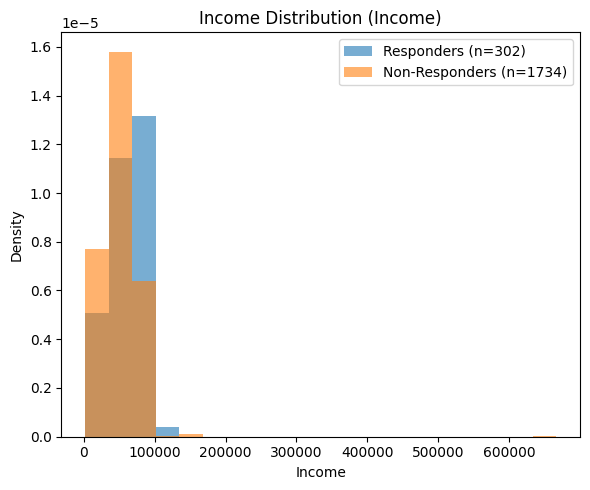

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- columns to use (auto-detects if possible)
income_candidates = ["Income","income_imputed","income"]
yob_candidates    = ["Year_Birth","year_birth","YEAR_BIRTH"]

income_col = next((c for c in income_candidates if c in dfw.columns), None)

# Age: prefer existing Age; else derive from Year_Birth
if "Age" in dfw.columns and dfw["Age"].notna().any():
    age_all = pd.to_numeric(dfw["Age"], errors="coerce")
else:
    yob_col = next((c for c in yob_candidates if c in dfw.columns), None)
    age_all = (pd.Timestamp.now().year - pd.to_numeric(dfw[yob_col], errors="coerce")) if yob_col else None

# Split masks
mask_resp = (dfw["_response_bin"] == 1)
mask_non  = (dfw["_response_bin"] == 0)

# Prepare data series
r_age  = age_all[mask_resp].dropna() if age_all is not None else None
nr_age = age_all[mask_non].dropna()  if age_all is not None else None

r_inc  = pd.to_numeric(dfw.loc[mask_resp, income_col], errors="coerce").dropna() if income_col else None
nr_inc = pd.to_numeric(dfw.loc[mask_non,  income_col], errors="coerce").dropna() if income_col else None

# Clip absurd ages for readability
if r_age is not None:  r_age  = r_age[(r_age >= 18) & (r_age <= 100)]
if nr_age is not None: nr_age = nr_age[(nr_age >= 18) & (nr_age <= 100)]

# Decide how many panels we can draw
make_age    = r_age is not None and (len(r_age) > 0 or (nr_age is not None and len(nr_age) > 0))
make_income = r_inc is not None and (len(r_inc) > 0 or (nr_inc is not None and len(nr_inc) > 0))

if not (make_age or make_income):
    print("Nothing to plot (no usable Age or Income data).")
else:
    ncols = 2 if (make_age and make_income) else 1
    fig, axes = plt.subplots(1, ncols, figsize=(12 if ncols==2 else 6, 5))
    if ncols == 1:
        axes = [axes]

    # Helper to build shared bins for fair comparison
    def shared_bins(series_a, series_b, bins=20):
        data = pd.concat([series_a, series_b]).values if (series_a is not None and series_b is not None and len(series_a)+len(series_b)>0) \
               else (series_a.values if series_a is not None else series_b.values)
        if data is None or len(data)==0:
            return bins
        return np.histogram_bin_edges(data, bins=bins)

    # Panel 1: Age
    if make_age:
        ax = axes[0]
        bins_age = shared_bins(r_age if r_age is not None else pd.Series([], dtype=float),
                               nr_age if nr_age is not None else pd.Series([], dtype=float),
                               bins=20)
        labels_plotted = []
        if r_age is not None and len(r_age)>0:
            ax.hist(r_age, bins=bins_age, alpha=0.6, label=f"Responders (n={len(r_age)})", density=True)
            labels_plotted.append("responders")
        if nr_age is not None and len(nr_age)>0:
            ax.hist(nr_age, bins=bins_age, alpha=0.6, label=f"Non-Responders (n={len(nr_age)})", density=True)
            labels_plotted.append("non-responders")
        ax.set_title("Age Distribution")
        ax.set_xlabel("Age")
        ax.set_ylabel("Density")
        if labels_plotted:
            ax.legend()
        else:
            ax.text(0.5, 0.5, "No Age data to plot", ha="center", va="center", transform=ax.transAxes)

    # Panel 2: Income (if available)
    if make_income:
        ax = axes[-1] if make_age else axes[0]
        bins_inc = shared_bins(r_inc if r_inc is not None else pd.Series([], dtype=float),
                               nr_inc if nr_inc is not None else pd.Series([], dtype=float),
                               bins=20)
        labels_plotted = []
        if r_inc is not None and len(r_inc)>0:
            ax.hist(r_inc, bins=bins_inc, alpha=0.6, label=f"Responders (n={len(r_inc)})", density=True)
            labels_plotted.append("responders")
        if nr_inc is not None and len(nr_inc)>0:
            ax.hist(nr_inc, bins=bins_inc, alpha=0.6, label=f"Non-Responders (n={len(nr_inc)})", density=True)
            labels_plotted.append("non-responders")
        ax.set_title(f"Income Distribution ({income_col if income_col else 'N/A'})")
        ax.set_xlabel("Income")
        ax.set_ylabel("Density")
        if labels_plotted:
            ax.legend()
        else:
            ax.text(0.5, 0.5, "No Income data to plot", ha="center", va="center", transform=ax.transAxes)

    plt.tight_layout()
    plt.show()


No usable Age or Year_Birth column found.


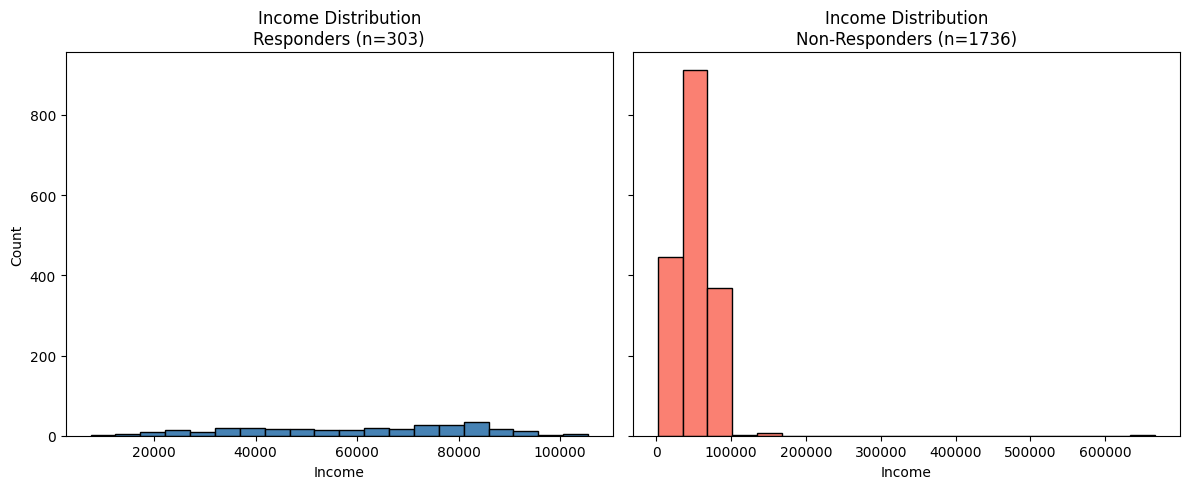

In [ ]:
# =========================================
# KPI Visuals: Side-by-Side Responders vs Non-Responders
# =========================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RESPONSE_COL = RESPONSE_COL if 'RESPONSE_COL' in globals() else "Response"
income_candidates = ["Income", "income_imputed", "income"]
yob_candidates = ["Year_Birth", "year_birth", "YEAR_BIRTH"]

# --- ensure _response_bin exists ---
if "_response_bin" not in dfw.columns:
    truthy = {"1","yes","true","y","oui","o","vrai","si"}
    falsy  = {"0","no","false","n","non","faux"}
    resp_str = dfw[RESPONSE_COL].astype(str).str.strip().str.lower()
    dfw["_response_bin"] = np.where(resp_str.isin(truthy), 1,
                             np.where(resp_str.isin(falsy), 0, np.nan))

# --- split responders/non-responders ---
responders     = dfw[dfw["_response_bin"] == 1].copy()
non_responders = dfw[dfw["_response_bin"] == 0].copy()

# --- detect usable columns ---
income_col = next((c for c in income_candidates if c in dfw.columns), None)
if "Age" in dfw.columns and dfw["Age"].notna().any():
    age_col = "Age"
else:
    yob_col = next((c for c in yob_candidates if c in dfw.columns), None)
    if yob_col is not None:
        dfw["Age"] = pd.Timestamp.now().year - pd.to_numeric(dfw[yob_col], errors="coerce")
        age_col = "Age"
    else:
        age_col = None

# --- function to create twin plots (responders vs non-responders) ---
def twin_hist(x_r, x_nr, xlabel, title, bins=20):
    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    
    axes[0].hist(x_r.dropna(), bins=bins, color="steelblue", edgecolor="black")
    axes[0].set_title(f"{title}\nResponders (n={len(x_r)})")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel("Count")

    axes[1].hist(x_nr.dropna(), bins=bins, color="salmon", edgecolor="black")
    axes[1].set_title(f"{title}\nNon-Responders (n={len(x_nr)})")
    axes[1].set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()

# --- AGE plots ---
if age_col and dfw[age_col].notna().any():
    twin_hist(responders[age_col], non_responders[age_col], xlabel="Age", title="Age Distribution")
else:
    print("No usable Age or Year_Birth column found.")

# --- INCOME plots ---
if income_col and dfw[income_col].notna().any():
    twin_hist(responders[income_col], non_responders[income_col], xlabel="Income", title="Income Distribution")
else:
    print("No usable Income column found.")



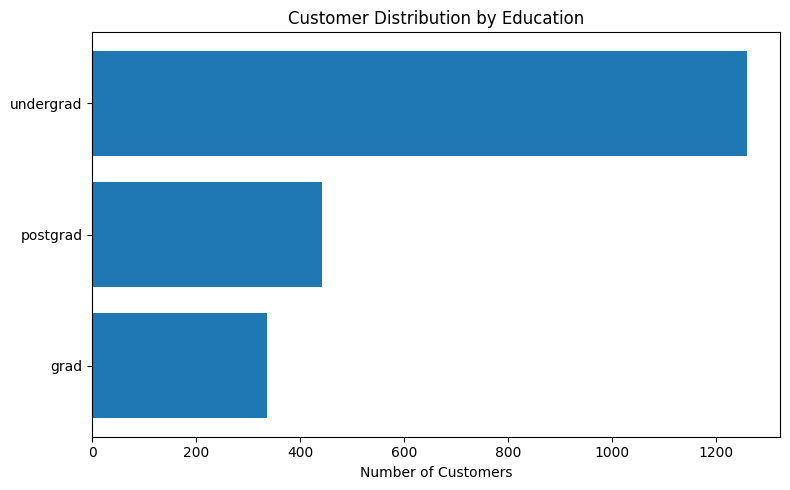

[Saved] plots/education_barh_counts.png


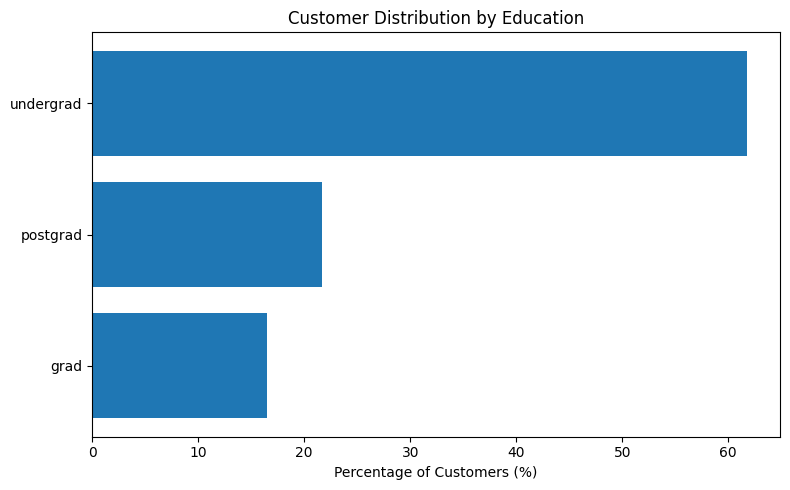

[Saved] plots/education_barh_pct.png


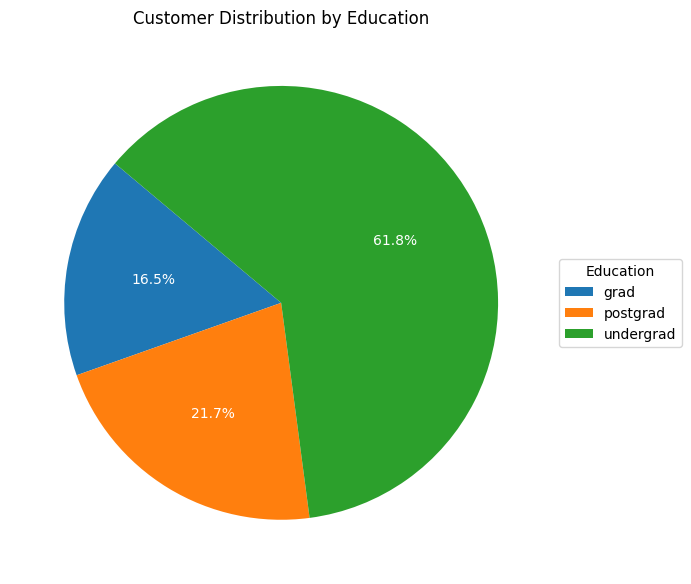

[Saved] plots/education_pie_clean.png


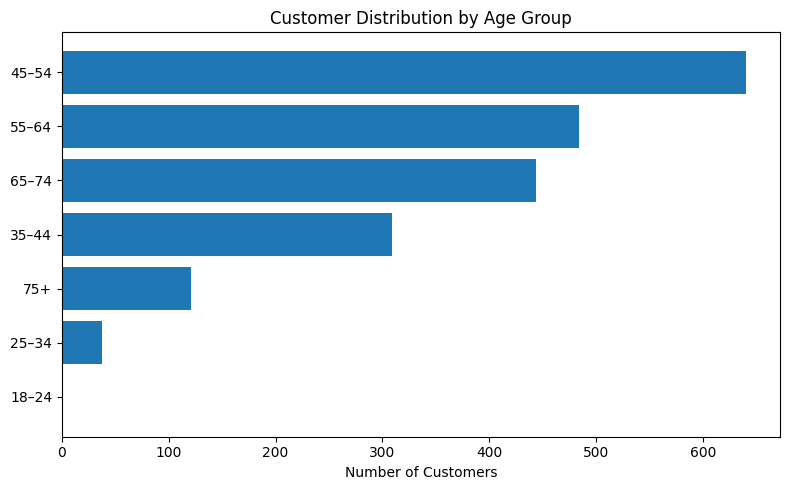

[Saved] plots/agegroup_barh_counts.png


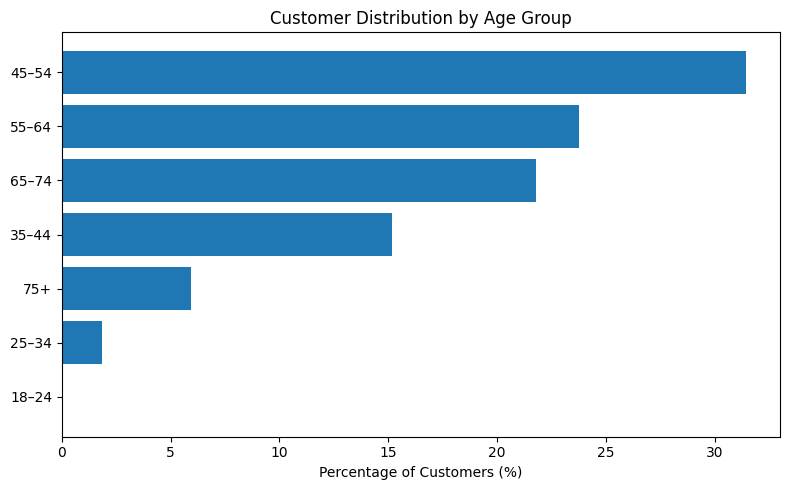

[Saved] plots/agegroup_barh_pct.png


In [ ]:
# ===========================
# 12) SEGMENTED KPI VISUALS (robust & clean)
# ===========================
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("plots", exist_ok=True)

def _is_df(x):
    return isinstance(x, pd.DataFrame) and not x.empty

def plot_barh_counts(tbl: pd.DataFrame, cat_col: str, title: str, outname: str):
    """Horizontal bar chart (counts)."""
    t = tbl[[cat_col, "n"]].copy()
    t = t.sort_values("n", ascending=True)
    plt.figure(figsize=(8, 5))
    plt.barh(t[cat_col].astype(str), t["n"])
    plt.xlabel("Number of Customers")
    plt.title(f"Customer Distribution by {title}")
    plt.tight_layout()
    fn = f"plots/{outname}_barh_counts.png"
    plt.savefig(fn, dpi=150)
    plt.show()
    print("[Saved]", fn)

def plot_barh_pct(tbl: pd.DataFrame, cat_col: str, title: str, outname: str):
    """Horizontal bar chart (percentages)."""
    t = tbl[[cat_col, "n"]].copy()
    t["pct"] = t["n"] / t["n"].sum() * 100
    t = t.sort_values("pct", ascending=True)
    plt.figure(figsize=(8, 5))
    plt.barh(t[cat_col].astype(str), t["pct"])
    plt.xlabel("Percentage of Customers (%)")
    plt.title(f"Customer Distribution by {title}")
    plt.tight_layout()
    fn = f"plots/{outname}_barh_pct.png"
    plt.savefig(fn, dpi=150)
    plt.show()
    print("[Saved]", fn)

def plot_pie_clean(tbl: pd.DataFrame, cat_col: str, title: str, outname: str):
    """Cleaner pie: % inside, labels in legend."""
    values = tbl["n"].values
    labels = tbl[cat_col].astype(str).values

    plt.figure(figsize=(7, 7))
    wedges, texts, autotexts = plt.pie(
        values,
        labels=None,          # keep labels in legend, not around slices
        autopct="%1.1f%%",    # % on slices
        startangle=140,
        textprops={'color': "white"}
    )
    plt.legend(
        wedges,
        labels,
        title=title,
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )
    plt.title(f"Customer Distribution by {title}")
    plt.tight_layout()
    fn = f"plots/{outname}_pie_clean.png"
    plt.savefig(fn, dpi=150)
    plt.show()
    print("[Saved]", fn)

def choose_and_plot(tbl: pd.DataFrame, cat_col: str, title: str, outname: str, prefer_barh=True):
    """
    If many categories or long labels -> barh (counts + %).
    If few categories (<=5) -> also create a clean pie for quick share.
    """
    if not _is_df(tbl) or cat_col not in tbl.columns:
        print(f"[Skip] {title}: no data.")
        return

    # Always make clear bar charts
    plot_barh_counts(tbl, cat_col, title, outname)
    plot_barh_pct(tbl, cat_col, title, outname)

    # Optional pie only when it's not cluttered
    if tbl.shape[0] <= 5:
        plot_pie_clean(tbl, cat_col, title, outname)

# -----------------------
# What do we have available?
# -----------------------
# Education table exists? (your grouped col is "education2")
if 'edu_resp' in locals() and _is_df(edu_resp):
    if "education2" in edu_resp.columns:
        choose_and_plot(edu_resp, "education2", "Education", "education")
    elif "Education" in edu_resp.columns:
        choose_and_plot(edu_resp, "Education", "Education", "education")
    else:
        print("[Skip] Education: expected 'education2' or 'Education' in table.")

# Marital table exists? (only if you actually built it)
if 'mar_resp' in locals() and _is_df(mar_resp):
    if "Marital_Status" in mar_resp.columns:
        choose_and_plot(mar_resp, "Marital_Status", "Marital Status", "marital_status")
    else:
        # If your column is named differently, change here.
        print("[Skip] Marital: expected 'Marital_Status' in table.")

# Age group table exists?
if 'age_resp' in locals() and _is_df(age_resp):
    if "AgeGroup" in age_resp.columns:
        choose_and_plot(age_resp, "AgeGroup", "Age Group", "agegroup")
    else:
        print("[Skip] Age Group: expected 'AgeGroup' in table.")


Matplotlib backend: inline


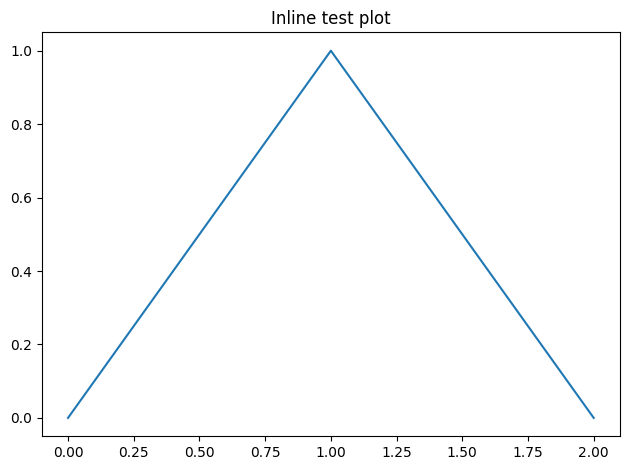

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print("Matplotlib backend:", matplotlib.get_backend())

plt.figure()
plt.plot([0,1,2],[0,1,0])
plt.title("Inline test plot")
plt.tight_layout()
plt.show()